In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
import xgboost as xgb

%matplotlib inline

data = pd.read_csv('./data/toronto-listings-2018-10.csv')
summary_data = pd.read_csv('./data/toronto-listings-summary-2018-10.csv')

print("Data Shape:", data.shape)

summary_data.head()

Data Shape: (17343, 96)


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,Unnamed: 16,Unnamed: 17
0,1419,Beautiful home in amazing area!,1565,Alexandra,NaN,Little Portugal,43.6461676615568,-79.4245101278309,Entire home/apt,469,4,7,2017-12-04,0.18,1,0.0,NaN,NaN
1,8077,Downtown Harbourfront Private Room,22795,Kathie & Larry,NaN,Waterfront Communities-The Island,43.6410512698272,-79.3762770057779,Private room,97,180,170,2013-08-27,1.53,2,365.0,NaN,NaN
2,10314,Union Inn II (Leslieville),35505,Douglas & Annie,NaN,South Riverdale,43.6701855037018,-79.3358478358527,Private room,69,1,77,2016-08-18,0.7,1,355.0,NaN,NaN
3,12604,Seaton Village Parlour Bedroom,48239,Rona,NaN,Annex,43.6672406861034,-79.4159775610911,Private room,65,1,0,NaN,NaN,1,0.0,NaN,NaN
4,23691,Queen Bedroom close to downtown,93825,Yohan & Sarah,NaN,Briar Hill-Belgravia,43.6960167412772,-79.4546827470826,Private room,70,1,201,2018-07-02,1.98,2,346.0,NaN,NaN


In [5]:
# index the record by the listing id
data.set_index('id', drop=True, inplace=True)
summary_data.set_index('id', drop=True, inplace=True)

# Inspecting the columns
data.columns

Index(['listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space',
       'description', 'experiences_offered', 'neighborhood_overview', 'notes',
       'transit', 'access', 'interaction', 'house_rules', 'thumbnail_url',
       'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url',
       'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'street',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedr

In [6]:
# Some of the columns with valuable data (i.e. data that can give us answers to our questions)
keep_cols = [
    "price", "neighbourhood_cleansed", "room_type", "bedrooms", "bed_type", "maximum_nights", "beds", 
    "property_type", "amenities", "number_of_reviews", "minimum_nights",
    "cleaning_fee", "instant_bookable",
    "review_scores_rating", # "reviews_per_month", "require_guest_phone_verification", "host_is_superhost",
    # "host_response_rate", "host_acceptance_rate", "weekly_price", "monthly_price",
]

# Define the categorical columns which will need dummy vars before modeling
cat_cols = ['property_type', 'bed_type', 'neighbourhood_cleansed', 'room_type']

data = data[keep_cols]

# columns with more than 15% missing data
cols_missing_some_data_15 = set(data.columns[data.isnull().mean() > 0.15])

# columns with more than 25% missing data
cols_missing_some_data_25 = set(data.columns[data.isnull().mean() > 0.25])

# columns with more than 50% missing data
cols_missing_lots_data = set(data.columns[data.isnull().mean() > 0.50])

print("Missing more than 15%", cols_missing_some_data_15)
print("Missing more than 25%", cols_missing_some_data_25)
print("Missing more than 50%", cols_missing_lots_data)

Missing more than 15% {'review_scores_rating', 'cleaning_fee'}
Missing more than 25% set()
Missing more than 50% set()


In [7]:
# Show a sample of the new df with less features
data.sample(25)

,price,neighbourhood_cleansed,room_type,bedrooms,bed_type,maximum_nights,beds,property_type,amenities,number_of_reviews,minimum_nights,cleaning_fee,instant_bookable,review_scores_rating
id,,,,,,,,,,,,,,
6953057,$85.00,Annex,Private room,1.0,Real Bed,1125,2.0,Guesthouse,"{Internet,Wifi,""Air conditioning"",Kitchen,Heat...",24,2,$20.00,f,91.0
13038664,$35.00,York University Heights,Private room,1.0,Real Bed,7,1.0,Bed and breakfast,"{TV,Internet,Wifi,Kitchen,""Smoking allowed"",""P...",16,1,NaN,f,97.0
26038348,$120.00,Kensington-Chinatown,Private room,1.0,Real Bed,1125,2.0,Apartment,"{Wifi,""Air conditioning"",Kitchen,""Paid parking...",7,1,$25.00,f,71.0
20712207,$125.00,Woodbine Corridor,Entire home/apt,1.0,Real Bed,14,2.0,Guest suite,"{TV,Wifi,""Air conditioning"",""Paid parking off ...",30,3,$40.00,f,95.0
6602120,$96.00,Annex,Entire home/apt,1.0,Real Bed,14,1.0,Apartment,"{TV,""Cable TV"",Internet,Wifi,Kitchen,Heating,W...",0,2,$25.00,f,NaN
13200089,$80.00,Cabbagetown-South St.James Town,Entire home/apt,0.0,Real Bed,35,1.0,Apartment,"{Wifi,Kitchen,Elevator,""Buzzer/wireless interc...",4,3,NaN,f,85.0
4728833,$140.00,Niagara,Entire home/apt,1.0,Real Bed,14,2.0,Loft,"{TV,Wifi,""Air conditioning"",Kitchen,""Free park...",22,3,$60.00,t,97.0
24452391,$65.00,Dovercourt-Wallace Emerson-Junction,Private room,1.0,Real Bed,21,1.0,House,"{Wifi,""Air conditioning"",Kitchen,""Free parking...",14,2,$35.00,f,98.0
15924982,$50.00,Bendale,Private room,1.0,Real Bed,1125,1.0,Condominium,"{TV,Wifi,""Air conditioning"",Kitchen,""Free park...",0,2,$10.00,f,NaN


In [8]:
def transform_bool(col_data):
    return col_data.apply(lambda x: 0 if x == 'f' else 1)

def clean_numeric_dollar(inputs):
    # transform price or cleaning_fee into a numberic value
    return inputs.str.replace('[$,]', '').astype('float')

# Cleans a column that is made up of lists, creates dummy vars for it
def create_dummies_from_list_col(inputs, col, suffix, other_min = 1000):
    mlb = MultiLabelBinarizer()
    
    dummies = pd \
        .DataFrame(mlb.fit_transform(inputs[col]), columns=mlb.classes_, index=inputs.index) \
        .add_suffix(suffix)

    others = dummies.sum() < 1000
    dummies_drop_cols = others[others == True].index
    
    dummies = dummies.drop(labels=dummies_drop_cols, axis='columns')

    return pd.concat([inputs.drop(col, axis=1), dummies], axis=1)


def create_dummies(inputs, col, dummy_na):
    dummies_df = pd.get_dummies(inputs[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=dummy_na)
    
    return pd.concat([inputs.drop(col, axis=1), dummies_df], axis=1)


def create_other_category(inputs, col, n_top=5):
    common_types = inputs[col].value_counts().head(n_top).index.values
    inputs.loc[~inputs[col].isin(common_types), col] = 'other'
    
    return inputs


def clean(inputs, include_dummies=True, dummy_na=False):
    df = inputs.copy()
    
    df.price = clean_numeric_dollar(df.price)
    
    # transform cleaning_fee into a numberic value
    df.cleaning_fee = clean_numeric_dollar(df.cleaning_fee)
    
    # transform "host_response_rate" into a numeric column, also fill missing values with mean
    # df.host_response_rate = df.host_response_rate.str.replace('%', '').astype('float')
    # df.host_response_rate = df.host_response_rate.mean()
    
    # replace least common property types with "other"
    df = create_other_category(df, col='property_type', n_top=7)
    df = create_other_category(df, col='room_type', n_top=7)
    df = create_other_category(df, col='bed_type', n_top=7)
    
    # Fill missing bedroom values
    # df.bedrooms = df.bedrooms.fillna(0) # assume studio / bachelor
    
    # transform the "amenities" into a column of arrays, then create dummy vals (0, 1) with many columns
    df.amenities = \
        df.amenities.apply(lambda x: set(x.replace('{', '').replace('}', '').replace('"', '').split(',')))
    
    if include_dummies:
        # NOTE: this adds 190+ columns, some of these are amenities that are very specific and may not be 
        #       worth considering, circle back and check if that is true
        df = create_dummies_from_list_col(df, col='amenities', suffix='_amenities')

        # transform bool columns such that 'f' = 0 and 't' = 1
        # df.host_is_superhost = transform_bool(df.host_is_superhost).fillna(0)
        df.instant_bookable = transform_bool(df.instant_bookable).fillna(0)
        # df.require_guest_phone_verification = transform_bool(df.require_guest_phone_verification).fillna(0)

        # transform all categorical columns into dummy columns

        # consider all non-common categories as 'other' to reduce number features when creating dummies
        # for c in [col for col in cat_cols if col not in ['neighbourhood_cleansed']]:
        #    common_types = df[c].value_counts().head(20).index.values
        #    df.loc[~df[c].isin(common_types), c] = 'other'

        # create dummies
        for col in  cat_cols:
            df = create_dummies(df, col=col, dummy_na=dummy_na)
    
    df = df[df.price <= (np.std(df.price) * 3)] # TODO: use std_dev of x3 to calculate outliers
    
    df = df.fillna(0)
    
    return df

In [9]:
df = clean(data)
df.describe()

,price,bedrooms,maximum_nights,beds,number_of_reviews,minimum_nights,cleaning_fee,instant_bookable,review_scores_rating,24-hour check-in_amenities,...,neighbourhood_cleansed_Woburn,neighbourhood_cleansed_Woodbine Corridor,neighbourhood_cleansed_Woodbine-Lumsden,neighbourhood_cleansed_Wychwood,neighbourhood_cleansed_Yonge-Eglinton,neighbourhood_cleansed_Yonge-St.Clair,neighbourhood_cleansed_York University Heights,neighbourhood_cleansed_Yorkdale-Glen Park,room_type_Private room,room_type_Shared room
count,17189.000000,17189.000000,1.718900e+04,17189.000000,17189.000000,17189.000000,17189.000000,17189.000000,17189.000000,17189.000000,...,17189.000000,17189.000000,17189.000000,17189.000000,17189.000000,17189.000000,17189.000000,17189.00000,17189.000000,17189.000000
mean,131.435395,1.294898,1.846134e+05,1.649369,24.603991,6.262144,46.899471,0.342137,78.203328,0.127465,...,0.002443,0.005410,0.002502,0.006050,0.005876,0.004189,0.008436,0.00512,0.335040,0.017628
std,100.731593,0.840011,1.806824e+07,1.059871,42.170835,28.103799,45.385810,0.474439,36.183350,0.333503,...,0.049372,0.073359,0.049955,0.077551,0.076431,0.064587,0.091460,0.07137,0.472018,0.131597
min,0.000000,0.000000,1.000000e+00,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,65.000000,1.000000,3.100000e+01,1.000000,2.000000,1.000000,10.000000,0.000000,86.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,100.000000,1.000000,1.125000e+03,1.000000,8.000000,2.000000,40.000000,0.000000,95.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
75%,160.000000,2.000000,1.125000e+03,2.000000,28.000000,3.000000,70.000000,1.000000,99.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000
max,727.000000,30.000000,2.147484e+09,30.000000,620.000000,1125.000000,879.000000,1.000000,100.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000


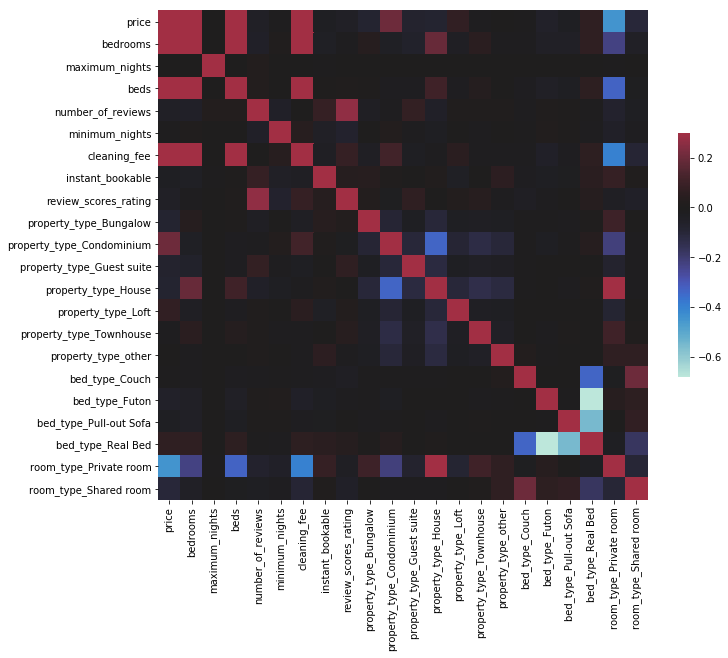

In [10]:
import seaborn as sns

def condition(c):
    return c not in ['longitude', 'latitude'] and \
    'amenities' not in c and \
    'neighbourhood' not in c

corr = df[[c for c in df.columns if condition(c)]].corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, vmax=.3, center=0, square=True, cbar_kws={"shrink": .5}, ax=ax)

/home/fizzler/anaconda3/envs/dsnd/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


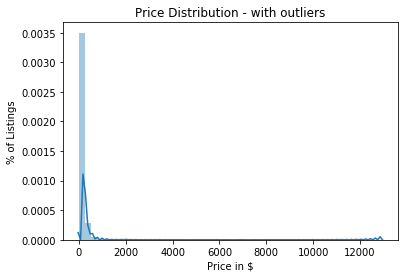

In [11]:
price_data = clean_numeric_dollar(data.price)

ax = sns.distplot(price_data)
ax.set(xlabel='Price in $', ylabel='% of Listings')
plt.title('Price Distribution - with outliers')
plt.show()

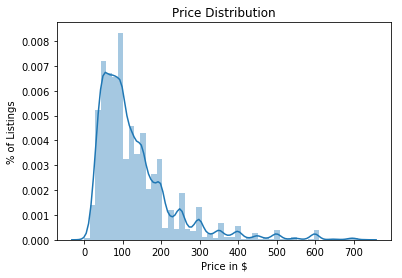

In [12]:
price_data_no_outliers = price_data[price_data < 3 * np.std(price_data)]

ax = sns.distplot(price_data_no_outliers)
ax.set(xlabel='Price in $', ylabel='% of Listings')
plt.title('Price Distribution')
plt.show()

### Neighbourhoods with Highest Listing Prices & Highest Price per Bed

In [13]:
clean_df = clean(data, include_dummies=False)

# assume 1 bed if the place has 0 beds (e.g. sofa bed)
clean_df['beds'] = clean_df['beds'].mask(clean_df['beds'] == 0, 1)
clean_df['price_per_bed'] = clean_df.price / clean_df.beds

grouped_by_hood = clean_df.groupby('neighbourhood_cleansed')
hood_mean = grouped_by_hood.mean()[['price', 'price_per_bed']]

In [14]:
# Neighbourhood with highest rates
display(hood_mean.sort_values(by=['price'], ascending=False).head(5).round(2))
display(hood_mean.sort_values(by=['price_per_bed'], ascending=False).head(5).round(2))

,price,price_per_bed
neighbourhood_cleansed,,
Waterfront Communities-The Island,191.83,124.92
Rosedale-Moore Park,174.61,117.98
Lawrence Park South,168.72,79.51
Bridle Path-Sunnybrook-York Mills,166.33,114.02
Lawrence Park North,164.93,68.55


,price,price_per_bed
neighbourhood_cleansed,,
Waterfront Communities-The Island,191.83,124.92
Rosedale-Moore Park,174.61,117.98
Niagara,158.23,114.36
Bridle Path-Sunnybrook-York Mills,166.33,114.02
Bay Street Corridor,147.45,107.69


In [15]:
# Estimate occupency rates
print(summary_data.columns)

occupancy_rates = \
    ((summary_data['reviews_per_month'] * summary_data['minimum_nights'])*12) / summary_data['availability_365']
occupancy_rates = occupancy_rates.apply(lambda x: x if np.isfinite(x) else .02) # default to 2%

summary_data['occupancy_rate'] = occupancy_rates.fillna(.02)
summary_data[summary_data['occupancy_rate'] > 1] = 1
summary_data['estimated_occupancy_percentage'] = occupancy_rates * 100

# summary_data[summary_data['estimated_occupancy_percentage'] > 50] = 50

summary_grouped_by_hood = summary_data.groupby('neighbourhood')
summary_hood_mean = summary_grouped_by_hood.mean()[['estimated_occupancy_percentage', 'price', 'minimum_nights', 'reviews_per_month']]

top_occupancy = summary_hood_mean[summary_hood_mean.estimated_occupancy_percentage < 100]\
    .sort_values(by=['estimated_occupancy_percentage'], ascending=False).head(10)
print(np.average(top_occupancy.price))
print(np.average(top_occupancy.minimum_nights))
print(np.average(top_occupancy.reviews_per_month))

Index(['name', 'host_id', 'host_name', 'neighbourhood_group', 'neighbourhood',
       'latitude', 'longitude', 'room_type', 'price', 'minimum_nights',
       'number_of_reviews', 'last_review', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365', 'Unnamed: 16',
       'Unnamed: 17'],
      dtype='object')


TypeError: can't multiply sequence by non-int of type 'str'

### Training & Testing The Model

In [18]:
def train_test(df, response_col='price', dummy_na=False, test_size=.3, rand_state=42, plot=False):
    #Split into explanatory and response variables
    X = df.drop(response_col, axis=1)
    y = df[response_col]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=rand_state)
    
#     lm_model = xgb.XGBRegressor(n_estimators=150, learning_rate=0.1, gamma=0, subsample=0.75,
#                            colsample_bytree=1, max_depth=9)
    lm_model = LinearRegression(normalize=True)
    lm_model.fit(X_train, y_train)
    
    train_preds = lm_model.predict(X_train)
    test_preds = lm_model.predict(X_test)
    
    train_score = r2_score(y_train, train_preds)
    test_score = r2_score(y_test, test_preds)

    return test_score, train_score, lm_model, X_train, X_test, y_train, y_test, test_preds

price_predict_df = df[[c for c in df.columns if c not in ['beds']]]
# price_predict_df = pd.concat([price_predict_df, summary_data['estimated_occupancy_percentage'].fillna(0)], axis=1)

test_score, train_score, lm_model, X_train, X_test, y_train, y_test, test_preds = \
    train_test(price_predict_df, dummy_na=False)
print(test_score, train_score)

0.4833245474577227 0.5251802816762619


In [285]:
# from sklearn.model_selection import GridSearchCV

# # The parameters grid below was built based on common values
# # From article linked below: 
# # https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
# grid_params = {
#     'n_estimators':[30, 50, 100, 150, 200], 
#     'gamma': [0, .1, .2, .5, .8],
#     'learning_rate': [.05, .1],
# }

# estimator = xgb.XGBRegressor(subsample=0.75, colsample_bytree=1, max_depth=9)
# grid_model = GridSearchCV(estimator, grid_params, cv=5)

# grid_model.fit(X_train, y_train)

# grid_preds = grid_model.predict(X_test)
# grid_score = r2_score(y_test, grid_preds)

# print("Grid search r2_score:", grid_score)
# print(grid_model.best_estimator_)

/home/fizzler/anaconda3/envs/dsnd/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


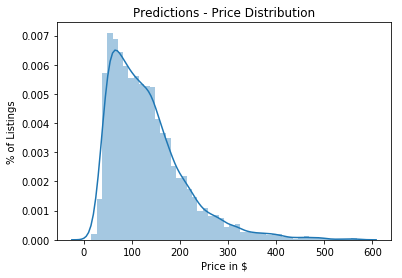

In [289]:
ax = sns.distplot(test_preds.tolist())
ax.set(xlabel='Price in $', ylabel='% of Listings')
plt.title('Predictions - Price Distribution')
plt.show()

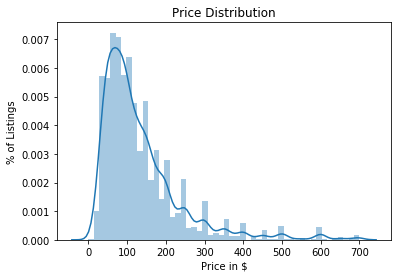

In [269]:
ax = sns.distplot(y_test.tolist())
ax.set(xlabel='Price in $', ylabel='% of Listings')
plt.title('Test - Price Distribution')
plt.show()

In [282]:
def coef_weights(coefficients, X_train):
    '''
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = lm_model.coef_
    coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df

#Use the function
coef_df = coef_weights(lm_model.coef_, X_train)

#A quick look at the top results
print(coef_df.head(5).round(2).to_csv())

,est_int,coefs,abs_coefs
206,neighbourhood_cleansed_Waterfront Communities-The Island,82.96,82.96
94,neighbourhood_cleansed_Beechborough-Greenbrook,82.35,82.35
90,neighbourhood_cleansed_Bay Street Corridor,66.44,66.44
107,neighbourhood_cleansed_Church-Yonge Corridor,64.54,64.54
225,room_type_Shared room,-64.34,64.34

